<a href="https://colab.research.google.com/github/anjanshrestha123/Technical-Analysis-For-Stock-Price-Prediction/blob/master/technical_analysis_for_stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Technical Analysis for Stock Price Prediction #


Reference (Citation): https://github.com/krishnaik06/Stock-MArket-Forecasting

**Todo:**
1. Create different models and compare accuracy
2. Cross validation and hyperparameter tuning
4. Predict Trend
5. Format Code

###Import and Packages###

In [1]:
# For dealing with dataframe
import pandas as pd

# For dealing with np array
import numpy as np

# For calling yahoo finance to get stock price 
import pandas_datareader as pdr
import datetime as dt
from datetime import timedelta

# For plotting
import matplotlib.pyplot as plt

# For model
import math
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import plot_confusion_matrix

# For upgrading pandas datareader module
!pip install --upgrade pandas_datareader

### Model Properties ###

In [2]:
# Yahoo Finance API Properties
NUMBER_OF_YEARS_TO_FETCH_PRICE_DATA = 30

# Dataset Properties
DATE = 'Date'
CLOSE = 'Close'
VOLUME = 'Volume'

# Stock Properties 
STOCK_TICKER = 'TSLA' # Stock ticker name to run the model

# Hyperparameters
NUMBER_OF_DAYS_FOR_PRICE_PREDICTION = 100
NUMBER_OF_DAYS_TO_PREDICT = 10
NUMBER_OF_EPOCHS = 25

##  1. Extract Raw data and Dataset Creation ##
Calling Yahoo Finance API to extract data for last 7 years from current date and convert it to dataframe

In [3]:
# Getting start and end date for stock data
end_date = dt.date.today()
start_date = end_date - timedelta(days=NUMBER_OF_YEARS_TO_FETCH_PRICE_DATA * 365)  # Getting start date as last 'n' number of years from now

# Calling Yahoo Finance API for last 7 years of stock data 
df = pdr.get_data_yahoo(STOCK_TICKER, start = start_date, end = end_date)

In [4]:
# Visualizing Dataset
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,5.000000,3.508000,3.800000,4.778000,93831500.0,4.778000
2010-06-30,6.084000,4.660000,5.158000,4.766000,85935500.0,4.766000
2010-07-01,5.184000,4.054000,5.000000,4.392000,41094000.0,4.392000
2010-07-02,4.620000,3.742000,4.600000,3.840000,25699000.0,3.840000
2010-07-06,4.000000,3.166000,4.000000,3.222000,34334500.0,3.222000
...,...,...,...,...,...,...
2021-11-10,1078.099976,987.309998,1010.409973,1067.949951,42802700.0,1067.949951
2021-11-11,1104.969971,1054.680054,1102.770020,1063.510010,22396600.0,1063.510010
2021-11-12,1054.500000,1019.200012,1047.500000,1033.420044,25182300.0,1033.420044


In [5]:
# Visualizing the shape of Dataset
df.shape

(2868, 6)

## 2. Exploratory Data Analysis

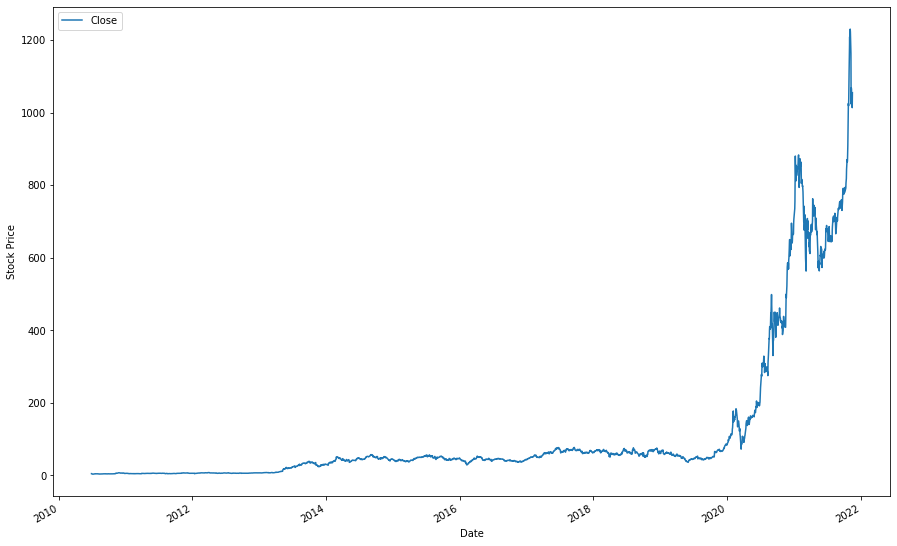

In [6]:
# Plotting the graph visualizing price change with date
df.plot(y=[CLOSE],figsize=(15,10), ylabel='Stock Price')

## 3. Feature Engineering ##

In [7]:
# Extracting Stock Closing Price as a Feature from Dataframe
model_df = df.reset_index()[CLOSE]
model_df

0          4.778000
1          4.766000
2          4.392000
3          3.840000
4          3.222000
           ...     
2863    1067.949951
2864    1063.510010
2865    1033.420044
2866    1013.390015
2867    1054.729980
Name: Close, Length: 2868, dtype: float64

## 4. Split Data into Train and Test ##

#### A. Split Data for LSTM Model ####

In [8]:
# Tranforming value to 0-1 since lstm are sensitive to the scale of the data
scaler = MinMaxScaler(feature_range=(0,1))
model_df_lstm = scaler.fit_transform(np.array(model_df).reshape(-1,1))
model_df_lstm

array([[0.00131893],
       [0.00130915],
       [0.00100428],
       ...,
       [0.83982883],
       [0.82350111],
       [0.85719988]])

In [9]:
# Split the first 70% of data to training set and last 30% to testing set since our dataset is time-series data
train_index_lstm = 0.7 * model_df_lstm.shape[0]
train_data_lstm = model_df_lstm[:int(train_index_lstm)]
test_data_lstm = model_df_lstm[int(train_index_lstm):]
test_data_lstm

array([[0.05490116],
       [0.05647768],
       [0.05407948],
       [0.05181659],
       [0.0517155 ],
       [0.05318117],
       [0.05358875],
       [0.05447402],
       [0.05333605],
       [0.05205135],
       [0.04810434],
       [0.04782718],
       [0.04778479],
       [0.04935154],
       [0.04999715],
       [0.0494249 ],
       [0.04905808],
       [0.04941023],
       [0.04798044],
       [0.05003301],
       [0.05022213],
       [0.04963195],
       [0.04854779],
       [0.04685551],
       [0.04591481],
       [0.04775871],
       [0.04741797],
       [0.04587406],
       [0.0447312 ],
       [0.04603057],
       [0.04647075],
       [0.05441043],
       [0.05418708],
       [0.05317954],
       [0.0593063 ],
       [0.05780151],
       [0.05488486],
       [0.05538047],
       [0.05553046],
       [0.05410067],
       [0.05264153],
       [0.0521133 ],
       [0.04723048],
       [0.0477098 ],
       [0.04990421],
       [0.04986183],
       [0.04961076],
       [0.050

In [10]:
# Function to create dataset into feature and target
def create_dataset_lstm(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)
        

In [11]:
# Creating dataset for training and testing
X_train_lstm, y_train_lstm = create_dataset_lstm(train_data_lstm, NUMBER_OF_DAYS_FOR_PRICE_PREDICTION)
X_test_lstm, y_test_lstm = create_dataset_lstm(test_data_lstm, NUMBER_OF_DAYS_FOR_PRICE_PREDICTION)

In [12]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

print('Training Shape: ', X_train_lstm.shape)
print('Testing Shape: ', X_test_lstm.shape)

Training Shape:  (1906, 100, 1)
Testing Shape:  (760, 100, 1)


#### B. Split Data for Other Model ####


In [13]:
# Split the first 70% of data to training set and last 30% to testing set since our dataset is time-series data
train_index = 0.7 * model_df.shape[0]
train_data = list(model_df[:int(train_index)])
test_data = list(model_df[int(train_index):])

In [14]:
# Function to create dataset into feature and target
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step-1):
        a = dataset[i:(i+time_step)]
        dataX.append(a)
        dataY.append(dataset[i+time_step])
    return np.array(dataX), np.array(dataY)

In [15]:
# Creating dataset for training and testing
X_train, y_train = create_dataset(train_data, NUMBER_OF_DAYS_FOR_PRICE_PREDICTION)
X_test, y_test= create_dataset(test_data, NUMBER_OF_DAYS_FOR_PRICE_PREDICTION)

## 5. Create, Train and Evaluate Model ##

In [16]:
# Common function to plot graph to evaluate Model
def plot_graph(model_df, model, X_train, X_test):
  # Making prediction for train and test set for plotting
  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)

  look_back = NUMBER_OF_DAYS_FOR_PRICE_PREDICTION
  train_predict_plot = [ np.nan for i in range(len(model_df))]
  train_predict_plot[look_back:len(train_predict) + look_back] = np.array(train_predict)

  # Shift test predictions for plotting
  test_predict_plot = [ np.nan for i in range(len(model_df))]
  test_predict_plot[len(train_predict) + (look_back*2)+1:len(model_df)-1] = list(test_predict)

  # Plot baseline and predictions
  plt.plot(model_df)
  plt.plot(train_predict_plot)
  plt.plot(test_predict_plot)
  plt.show()


### A. LSTM Model ###

#### I. Create and Train Model ####

In [17]:
# Create Stacked LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(NUMBER_OF_DAYS_FOR_PRICE_PREDICTION,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(X_train_lstm, y_train_lstm, validation_data=(X_test_lstm, y_test_lstm), epochs=NUMBER_OF_EPOCHS, batch_size=64, verbose=1)

Epoch 1/25
30/30 [==============================] - 14s 261ms/step - loss: 1.6662e-04 - val_loss: 0.0075
Epoch 2/25
30/30 [==============================] - 6s 215ms/step - loss: 1.3958e-05 - val_loss: 0.0069
Epoch 3/25
30/30 [==============================] - 6s 209ms/step - loss: 8.2102e-06 - val_loss: 0.0045
Epoch 4/25
30/30 [==============================] - 6s 211ms/step - loss: 6.9128e-06 - val_loss: 0.0057
Epoch 5/25
30/30 [==============================] - 6s 212ms/step - loss: 6.4913e-06 - val_loss: 0.0047
Epoch 6/25
30/30 [==============================] - 6s 212ms/step - loss: 6.9503e-06 - val_loss: 0.0042
Epoch 7/25
30/30 [==============================] - 6s 213ms/step - loss: 6.7499e-06 - val_loss: 0.0041
Epoch 8/25
30/30 [==============================] - 6s 210ms/step - loss: 6.2867e-06 - val_loss: 0.0047
Epoch 9/25
30/30 [==============================] - 6s 212ms/step - loss: 5.9784e-06 - val_loss: 0.0038
Epoch 10/25
30/30 [==============================] - 6s 211ms/s

#### II. Evaluate LSTM ####

In [19]:
# Predict and check performance metrics
train_predict_lstm = model.predict(X_train_lstm)
test_predict_lstm = model.predict(X_test_lstm)

In [20]:
# Transform back to original form
train_predict_lstm = scaler.inverse_transform(train_predict_lstm)
test_predict_lstm = scaler.inverse_transform(test_predict_lstm)

In [21]:
# Test Data RMSE
rmse_lstm = math.sqrt(mean_squared_error(y_test_lstm, test_predict_lstm))
rmse_lstm

381.06165437250706

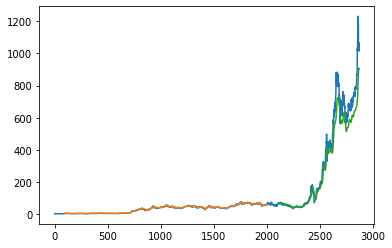

In [22]:
# Shift train predictions for plotting
look_back = NUMBER_OF_DAYS_FOR_PRICE_PREDICTION
train_predict_plot = np.empty_like(model_df_lstm)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict_lstm) + look_back, :] = train_predict_lstm

# Shift test predictions for plotting
test_predict_plot = np.empty_like(model_df_lstm)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict_lstm) + (look_back*2)+1:len(model_df_lstm)-1, :] = test_predict_lstm

# Plot baseline and predictions
plt.plot(scaler.inverse_transform(model_df_lstm))
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()


### B. Linear Regression Model ###

### I. Create and Train Model ###

In [23]:
# Create and Train Linear Regression Model
reg = LinearRegression().fit(X_train, y_train)

### II. Evaluate Model ###

In [24]:
# Test Data RMSE
rmse_reg = math.sqrt(mean_squared_error(reg.predict(X_test), y_test))
rmse_reg

18.045901025654945

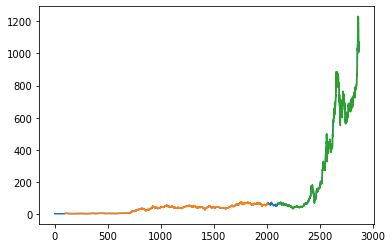

In [25]:
# Plot train and test prediction in graph
plot_graph(model_df, reg, X_train, X_test)

### C. Decision Tree Regression Model ###

#### I. Create and Train Model ####

In [26]:
# Create and Train Decision Tree Model
d_tree = DecisionTreeRegressor().fit(X_train, y_train)

#### II. Evaluate Decision Tree Regression ####

In [27]:
# Test Data RMSE
rmse_tree = math.sqrt(mean_squared_error(d_tree.predict(X_test), y_test))
rmse_tree

399.39972019580273

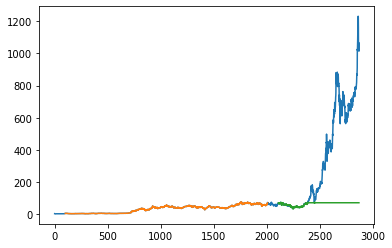

In [28]:
# Plot train and test prediction in graph
plot_graph(model_df, d_tree, X_train, X_test)

### D. KNN Regression Model ###

#### I. Create and Train Model ####


In [29]:
knn = KNeighborsRegressor().fit(X_train, y_train)

#### II. Evaluate Model ####

In [30]:
# Test Data RMSE
rmse_knn = math.sqrt(mean_squared_error(knn.predict(X_test), y_test))
rmse_knn

402.37747884252946

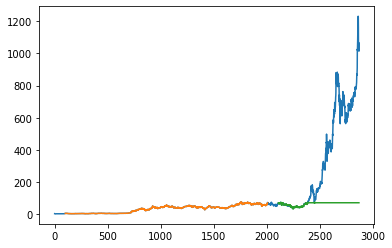

In [31]:
# Plot train and test prediction in graph
plot_graph(model_df, d_tree, X_train, X_test)

## 6. Comparing and Choosing Best Model ##

In [32]:
# Add code to compare and choose best model 

## 7. Predict Stock Market movement Trend for Next 30 Days Using Best Model ##

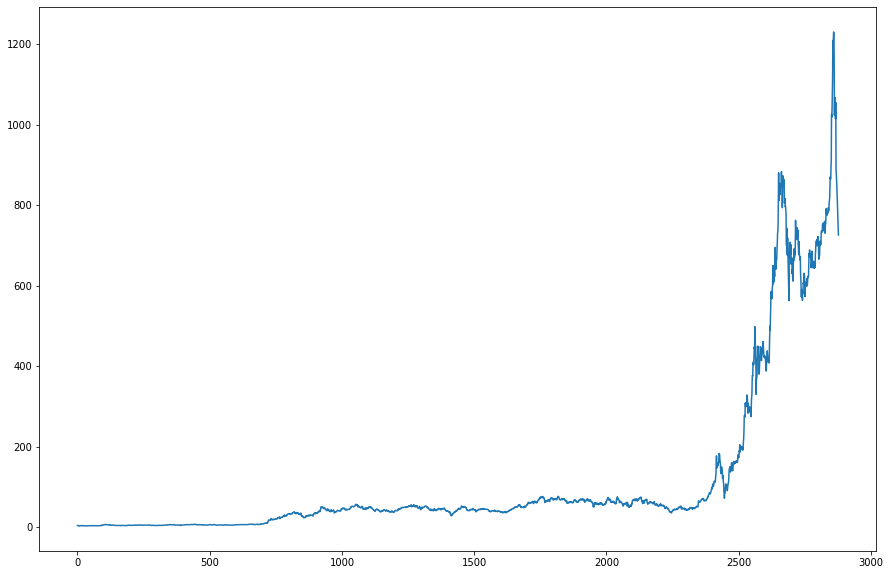

In [33]:
# For LSTM
lastest_data_index = len(test_data_lstm) - NUMBER_OF_DAYS_FOR_PRICE_PREDICTION
x_input=test_data_lstm[lastest_data_index:].reshape(1,-1)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

# demonstrate prediction for next n days
lst_output=[]
n_steps=NUMBER_OF_DAYS_FOR_PRICE_PREDICTION
i=0
while(i<NUMBER_OF_DAYS_TO_PREDICT):
    
    if(len(temp_input)>NUMBER_OF_DAYS_FOR_PRICE_PREDICTION):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

day_new=np.arange(1,NUMBER_OF_DAYS_FOR_PRICE_PREDICTION + 1)
day_pred=np.arange(NUMBER_OF_DAYS_FOR_PRICE_PREDICTION + 1, NUMBER_OF_DAYS_FOR_PRICE_PREDICTION + NUMBER_OF_DAYS_TO_PREDICT + 1)

lastest_model_df_index = len(model_df_lstm) - NUMBER_OF_DAYS_FOR_PRICE_PREDICTION

df3=model_df_lstm.tolist()
df3.extend(lst_output)
df3=scaler.inverse_transform(df3).tolist()

plt.figure(figsize=(15,10))
plt.plot(df3)

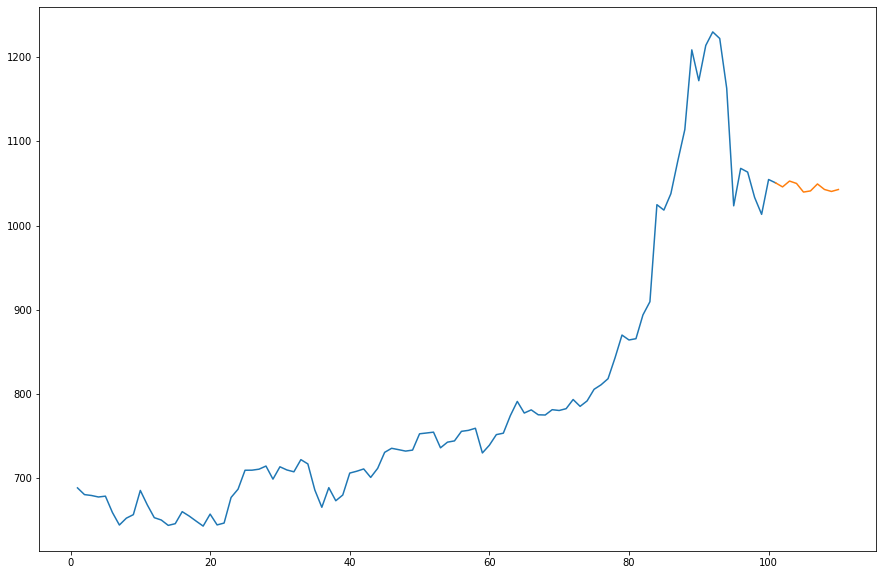

In [34]:
# For other model
lastest_data_index = len(test_data) - NUMBER_OF_DAYS_FOR_PRICE_PREDICTION
x_input=test_data[lastest_data_index:]

temp_input=list(x_input)
temp_input=[temp_input[0]]

# demonstrate prediction for next n days
lst_output = []
last_n_days_data = test_data[lastest_data_index : ]
next_day = None
for day in range(NUMBER_OF_DAYS_TO_PREDICT):
  if next_day is not None:
    last_n_days_data = last_n_days_data[1:]
    last_n_days_data.append(next_day)
  next_day = reg.predict([last_n_days_data])[0]
  lst_output.append(next_day)

day_new=np.arange(1,NUMBER_OF_DAYS_FOR_PRICE_PREDICTION + 2)
day_pred=np.arange(NUMBER_OF_DAYS_FOR_PRICE_PREDICTION + 1, NUMBER_OF_DAYS_FOR_PRICE_PREDICTION + NUMBER_OF_DAYS_TO_PREDICT + 1)

lastest_model_df_index = len(model_df) - NUMBER_OF_DAYS_FOR_PRICE_PREDICTION

plt.figure(figsize=(15,10))

last_n_days = list(model_df[lastest_model_df_index:])
last_n_days.append(lst_output[0])

plt.plot(day_new,last_n_days)
plt.plot(day_pred,lst_output)

In [35]:
model_df.iloc[-1]

1054.72998046875

## 8. Predict Stock Price for Next Day Using Best Model ##

In [38]:
# Next day price using other model
last_n_days_data=test_data[len(test_data) - NUMBER_OF_DAYS_FOR_PRICE_PREDICTION:]
next_day = reg.predict([last_n_days_data])[0]
next_day

1050.7683046328389